Reference:
- https://www.kaggle.com/ruthgn/bank-marketing-data-set # Dataset
- https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
- https://stackoverflow.com/questions/46943314/xgboost-plot-importance-doesnt-show-feature-names
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
- https://datavizpyr.com/how-to-annotate-bars-in-grouped-barplot-in-python/
- https://stackoverflow.com/questions/31417487/sklearn-logisticregression-and-changing-the-default-threshold-for-classification

### 1. Import package

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style('whitegrid')
from scipy.stats import norm, skew, uniform
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, \
classification_report, plot_roc_curve, plot_precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os  
import xgboost as xgb

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#@markdown 1.1 Define functions

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)== cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### 2. Import data

#### 2.0 Variable description

Input variables:

**Bank client data:**
1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')


**Related with the last contact of the current campaign:**

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')

10 - dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

**Other attributes:**

11 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

12 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

13 - previous: number of contacts performed before this campaign and for this client (numeric)

14 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**Social and economic context attributes:**

15 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

16 - cons.price.idx: consumer price index - monthly indicator (numeric)

17 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

18 - euribor3m: euribor 3 month rate - daily indicator (numeric)

19 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

20 - y - has the client subscribed a term deposit? (binary: 'yes','no')

#### 2.1 Import Data

In [ ]:
'''
Load data from the cloud drive.

'''

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/02. EAI 6000/Data' 
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/02. EAI 6000/Data
 Annotating_Bars_in_Grouped_Barplot_Seaborn_Matplotlib_try1.png
 Bank.csv
'Descriptive table.csv'
 Telco-Customer-Churn.csv
'tree graph.png'


In [ ]:
df = pd.read_csv('Bank.csv')
print(df.shape)
df.head(2)

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df = df.rename(columns = {'default': 'has_credit', 'contact': 'contact_type', 'pdays': 'day_passed_since_last_contact',
                          'poutcome': 'pre_outcome', 'emp.var.rate': 'employment_variation_rate', 
                          'cons.price.idx': 'consumer_price_index', 'cons.conf.idx': 'consumer_confidence_index', 
                          'nr.employed': 'number_of_employees', 'y': 'Subscribed'})

In [ ]:
print(df.shape)
df.head(2)

(41188, 20)


,age,job,marital,education,has_credit,housing,loan,contact_type,month,day_of_week,campaign,day_passed_since_last_contact,previous,pre_outcome,employment_variation_rate,consumer_price_index,consumer_confidence_index,euribor3m,number_of_employees,Subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 3. Data Preprocessing

#### 3.1 Data Cleansing

##### 3.1.1 Check and Remove duplicated data (if any)

In [ ]:
print(df.shape)
df.duplicated().value_counts()

(41188, 20)


False    39404
True      1784
dtype: int64

In [ ]:
df.drop_duplicates(inplace = True)
df.shape

(39404, 20)

##### 3.1.2 Clean features

In [ ]:
# Clean Feature - day_passed_since_last_contact

def pass_day_cluster(x):
  if x < 11:
    return 'within 10 days'
  elif x < 21:
    return 'Between 11 and 20 days'
  elif x < 31:
    return 'Between 21 and 30 days'
  else:
    return 'Never contact'

df['day_passed_since_last_contact'] = df['day_passed_since_last_contact'].apply(lambda x: pass_day_cluster(x))

In [ ]:
df['day_passed_since_last_contact'].value_counts()

Never contact             37890
within 10 days             1310
Between 11 and 20 days      196
Between 21 and 30 days        8
Name: day_passed_since_last_contact, dtype: int64

##### 3.1.3 Check and Remove outliers (if any)

In [ ]:
categorical_features = []

for col in df.columns:
    col_type = df[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[col] = df[col].astype('category')
        categorical_features.append(col)

print(categorical_features)

['job', 'marital', 'education', 'has_credit', 'housing', 'loan', 'contact_type', 'month', 'day_of_week', 'day_passed_since_last_contact', 'pre_outcome', 'Subscribed']


In [ ]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

numerical_features = Diff(df.columns, categorical_features)
print(numerical_features)

['previous', 'number_of_employees', 'employment_variation_rate', 'campaign', 'consumer_confidence_index', 'age', 'euribor3m', 'consumer_price_index']


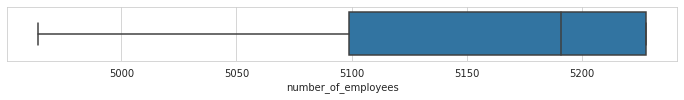

In [ ]:
plt.figure(figsize = (12, 1))
sns.boxplot(data = df, x = 'number_of_employees')

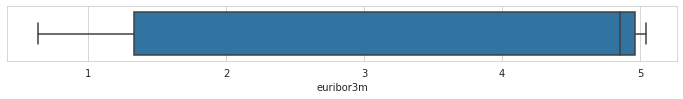

In [ ]:
plt.figure(figsize = (12, 1))
sns.boxplot(data = df, x = 'euribor3m')

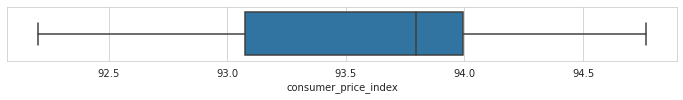

In [ ]:
plt.figure(figsize = (12, 1))
sns.boxplot(data = df, x = 'consumer_price_index')

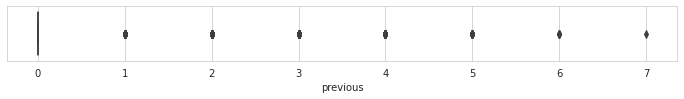

In [ ]:
plt.figure(figsize = (12, 1))

sns.boxplot(data = df, x = 'previous')

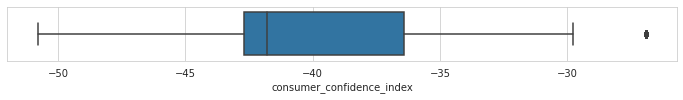

In [ ]:
plt.figure(figsize = (12, 1))
sns.boxplot(data = df, x = 'consumer_confidence_index')

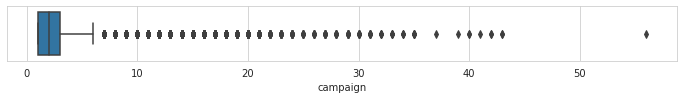

In [ ]:
plt.figure(figsize = (12, 1))
sns.boxplot(data = df, x = 'campaign')

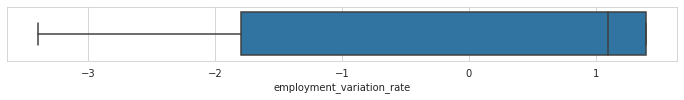

In [ ]:
plt.figure(figsize = (12, 1))
sns.boxplot(data = df, x = 'employment_variation_rate')

#### 3.2 Data imputation

In [ ]:
# for col in df.columns:
#   df[col] = df[col].replace('unknown', np.nan)

In [ ]:
# missing = pd.Series(1 - df.count()/len(df)).sort_values(ascending = True)
# missing = missing[missing > 0]

# fig, ax = plt.subplots(figsize =(10, 2))
# ax.barh(missing.index, missing)


# # Add annotation to bars
# for i in ax.patches:
#     plt.text(max(i.get_width(), 0) + 0.003, 
#              i.get_y() + 0.15,
#              str(round((i.get_width()), 3)),
#              fontsize = 12, fontweight ='bold',
#              color ='grey')
# plt.title('The percentage of missing value of each feature', fontsize = 14)

In [ ]:
# cols_contain_missing_value = ['has_credit', 'education', 'housing', 'loan', 'job', 'marital']

# for col in cols_contain_missing_value:
#   df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
df.isnull().sum()

age                              0
job                              0
marital                          0
education                        0
has_credit                       0
housing                          0
loan                             0
contact_type                     0
month                            0
day_of_week                      0
campaign                         0
day_passed_since_last_contact    0
previous                         0
pre_outcome                      0
employment_variation_rate        0
consumer_price_index             0
consumer_confidence_index        0
euribor3m                        0
number_of_employees              0
Subscribed                       0
dtype: int64

#### 3.3 Data transformation

In [ ]:
df['Subscribed'].value_counts()/len(df)

no     0.883311
yes    0.116689
Name: Subscribed, dtype: float64

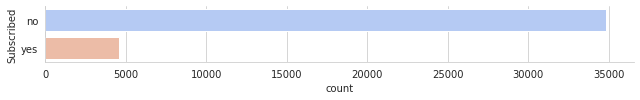

In [ ]:
# Check that do we have imbalance data
ax = sns.catplot(kind = 'count', data = df, y = 'Subscribed', palette = 'coolwarm', height = 1.5, aspect = 6)


In [ ]:
df_dummies = pd.get_dummies(df.copy(), drop_first = True)
df_dummies.shape

(39404, 55)

In [ ]:
# Due to the positive sample is too few, so we use SMOTE to generate some positive samples

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
X = df_dummies.drop('Subscribed_yes', axis = 1).copy()
y = df_dummies.Subscribed_yes.copy()
oversample = SMOTE(sampling_strategy = 0.3)
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
counter

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 34806, 1: 17403})

### 4. EDA

#### 4.1 Descriptive Table

In [ ]:
df.describe().transpose().to_csv('Descriptive table.csv')
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,39404.0,40.116105,10.460328,17.000,32.000,38.000,47.000,98.000
campaign,39404.0,2.618744,2.814780,1.000,1.000,2.000,3.000,56.000
previous,39404.0,0.178738,0.503172,0.000,0.000,0.000,0.000,7.000
employment_variation_rate,39404.0,0.064067,1.577041,-3.400,-1.800,1.100,1.400,1.400
consumer_price_index,39404.0,93.577538,0.583820,92.201,93.075,93.798,93.994,94.767
consumer_confidence_index,39404.0,-40.499604,4.644327,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,39404.0,3.601243,1.742337,0.634,1.334,4.857,4.961,5.045
number_of_employees,39404.0,5165.986481,72.763866,4963.600,5099.100,5191.000,5228.100,5228.100


#### 4.2 EDA 1. The difference in age between term deposit subscribers and unsubscibers

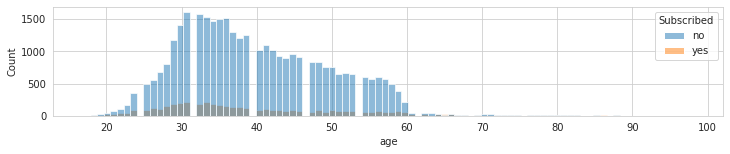

In [ ]:
plt.figure(figsize = (12, 2))
sns.histplot(data = df, x = 'age', hue = 'Subscribed')

#### 4.3 EDA 2. Which day of week has a higher subscription rate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


[Text(0.5, 0, 'Day of week')]

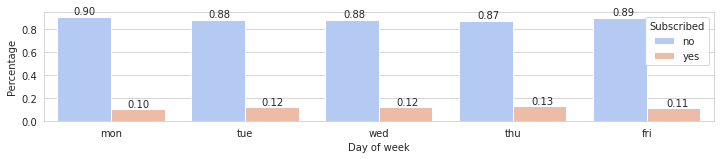

In [ ]:
df_wd = pd.DataFrame({'Count' : df.copy().groupby(['day_of_week', 'Subscribed']).size()}).reset_index()

def total_check(x):
  return int(len(df[df['day_of_week'] == x]))

df_wd['Total_of_week'] = df_wd['day_of_week'].apply(lambda x: total_check(x))
df_wd['Count']         = pd.to_numeric(df_wd['Count'])
df_wd['Total_of_week'] = pd.to_numeric(df_wd['Total_of_week'])
df_wd['Percentage']    = round(df_wd['Count'] / df_wd['Total_of_week'], 2)

plt.figure(figsize = (12, 2))
g = sns.barplot(data = df_wd, x = 'day_of_week', y = 'Percentage', hue = 'Subscribed',
                palette = 'coolwarm',
                order = ['mon', 'tue', 'wed', 'thu', 'fri'])

for p in g.patches:
  g.annotate(format(p.get_height(), '.2f'), 
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', va = 'bottom', 
             size= 10,
             textcoords = 'offset points')
g.set(xlabel='Day of week')

#### 4.4 EDA 3. Peoplein which job are likely to subscribe a term deposit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

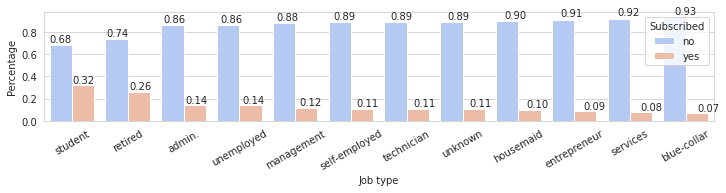

In [ ]:
df_job = pd.DataFrame({'Count' : df.copy().groupby(['job', 'Subscribed']).size()}).reset_index()

def total_check(x):
  return int(len(df[df['job'] == x]))

df_job['Total_of_job'] = df_job['job'].apply(lambda x: total_check(x))
df_job['Count']        = pd.to_numeric(df_job['Count'])
df_job['Total_of_job'] = pd.to_numeric(df_job['Total_of_job'])
df_job['Percentage']    = round(df_job['Count'] / df_job['Total_of_job'], 2)

plt.figure(figsize = (12, 2))
g = sns.barplot(data = df_job, x = 'job', y = 'Percentage', 
                hue = 'Subscribed', palette = 'coolwarm',
                order = df_job[df_job['Subscribed'] == 'no'].sort_values('Percentage').job)

for p in g.patches:
  g.annotate(format(p.get_height(), '.2f'), 
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', va = 'bottom', 
             size= 10,
             textcoords = 'offset points')
g.set(xlabel='Job type')
plt.xticks(rotation=30)

### 5. Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test  = scaler.transform(x_test)

0.7957287875885846


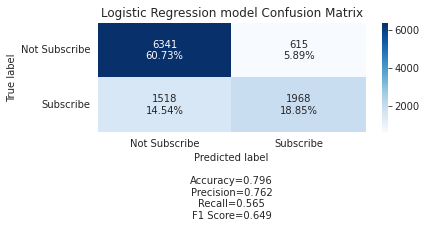

In [ ]:
log_model = LogisticRegression(solver='liblinear')

log_model.fit(scaled_x_train, y_train)
y_pred = log_model.predict(scaled_x_test)
print(accuracy_score(y_test, y_pred))

matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, figsize=(6,2), categories = ['Not Subscribe', 'Subscribe'], title = 'Logistic Regression model Confusion Matrix')

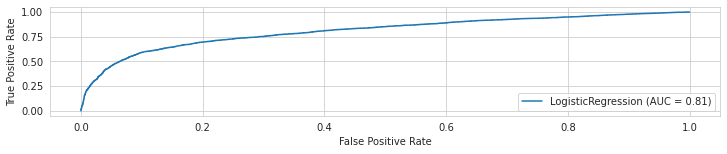

In [ ]:
fig, ax = plt.subplots(figsize = (12, 2))
plot_roc_curve(log_model, scaled_x_test, y_test, ax = ax)

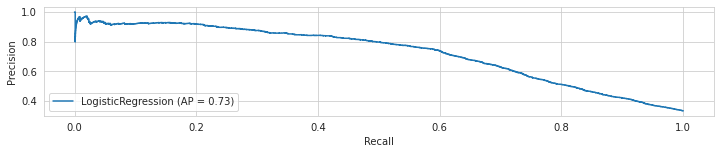

In [ ]:
fig, ax = plt.subplots(figsize = (12, 2))
plot_precision_recall_curve(log_model, scaled_x_test, y_test, ax = ax)

In [ ]:
# log_model = LogisticRegression(solver='saga', max_iter = 5000)
# penalty = ['l1', 'l2', 'elasticnet']
# l1_ratio = np.linspace(0, 1, 20)
# C = np.logspace(0, 10, 20)
# param_grid = {'penalty': penalty,
#               'l1_ratio': l1_ratio,
#               'C': C}
# grid_model = GridSearchCV(log_model, param_grid = param_grid)
# grid_model.fit(scaled_x_train, y_train)
# print(grid_model.best_paras_)
# y_pred = grid_model.predict(scaled_x_test)
# print(accuracy_score(y_test, y_pred))

# matrix = confusion_matrix(y_test, y_pred)
# make_confusion_matrix(matrix, figsize=(6,2), categories = ['Not Subscribe', 'Subscribe'], title = 'Logistic Regression model Confusion Matrix')

### 6.XGBoost

In [ ]:
# Creating the XGBClassfier shell
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective='binary:logistic', missing = None, seed = 101)

# Adding the data and fitting the model
# Instead of finding the optimal # of tress using K-Cross Validation, let's use early stopping to stop the tree when the cost function no longer reduces
# XGBoost will do the cross validation for us; we just have to specifiy the # of rounds to exhaust with no improvement before stopping
# We use evaluation metric as Area Under Precision-Recall Curve
xgb_model.fit(x_train,
              y_train,
              verbose=True,
              early_stopping_rounds = 200,
              eval_metric='aucpr',
              eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.725787
Will train until validation_0-aucpr hasn't improved in 200 rounds.
[1]	validation_0-aucpr:0.731914
[2]	validation_0-aucpr:0.742631
[3]	validation_0-aucpr:0.745364
[4]	validation_0-aucpr:0.751426
[5]	validation_0-aucpr:0.750414
[6]	validation_0-aucpr:0.751667
[7]	validation_0-aucpr:0.757385
[8]	validation_0-aucpr:0.757022
[9]	validation_0-aucpr:0.771838
[10]	validation_0-aucpr:0.791326
[11]	validation_0-aucpr:0.799191
[12]	validation_0-aucpr:0.812555
[13]	validation_0-aucpr:0.820532
[14]	validation_0-aucpr:0.823633
[15]	validation_0-aucpr:0.824992
[16]	validation_0-aucpr:0.829892
[17]	validation_0-aucpr:0.84093
[18]	validation_0-aucpr:0.842389
[19]	validation_0-aucpr:0.844124
[20]	validation_0-aucpr:0.848961
[21]	validation_0-aucpr:0.855497
[22]	validation_0-aucpr:0.859592
[23]	validation_0-aucpr:0.861664
[24]	validation_0-aucpr:0.864195
[25]	validation_0-aucpr:0.870614
[26]	validation_0-aucpr:0.873466
[27]	validation_0-aucpr:0.87879
[28]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=101,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_model.base_score

0.5

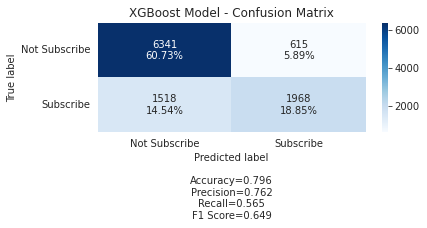

In [ ]:
# Confusion Matrix on the test data
matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, figsize=(6,2), categories = ['Not Subscribe', 'Subscribe'], title = 'XGBoost Model - Confusion Matrix')

In [ ]:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [7859 2583]]


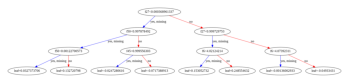

In [ ]:
xgb.plot_tree(xgb_model, num_trees = 20)
plt.rcParams['figure.figsize'] = [30, 20]
plt.show()

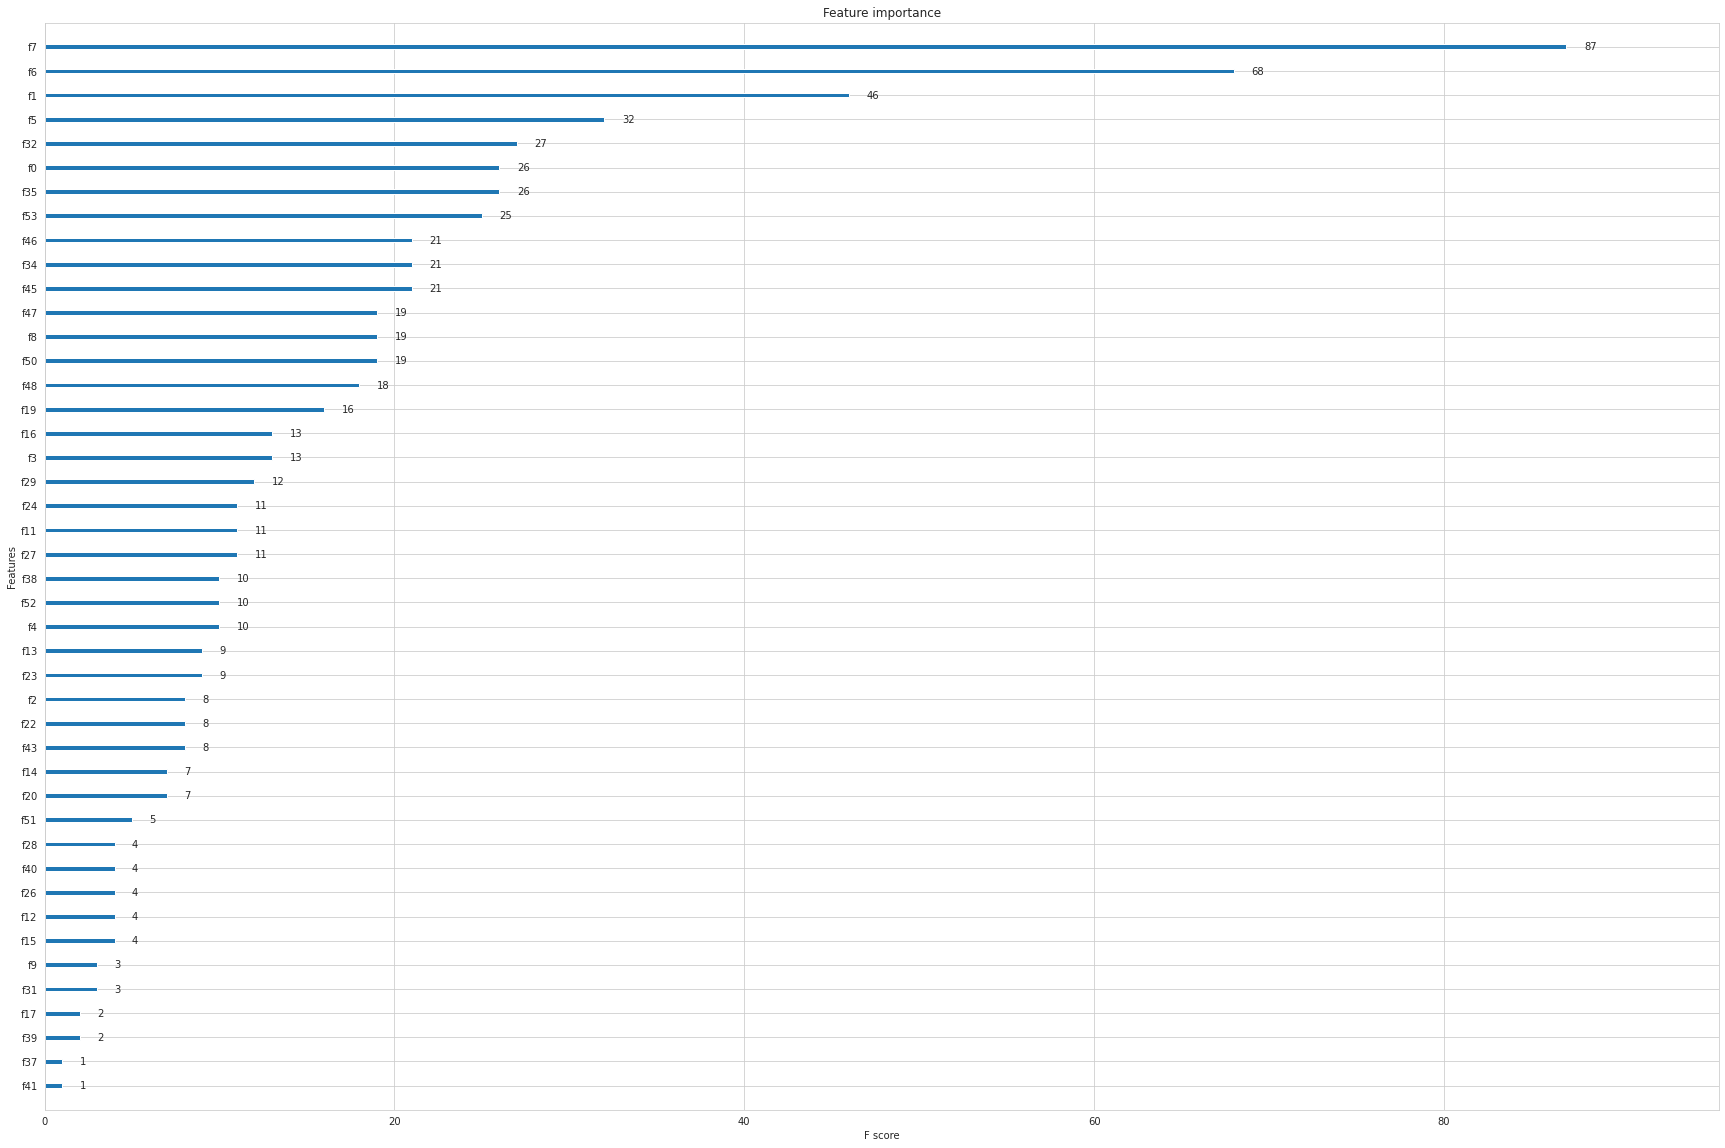

In [ ]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [5, 15]
plt.show()

### 7. Decision Tree

Text(0, 0.5, 'Testing Accuracy')

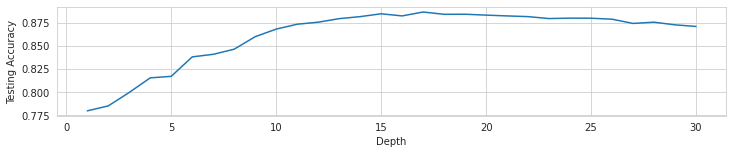

In [ ]:
from sklearn.tree import DecisionTreeClassifier

accuracy = []
for i in range(1, 31):
  dt_model = DecisionTreeClassifier(criterion = "entropy", max_depth = i, random_state = 0)
  dt_model.fit(x_train, y_train)
  y_pred = pd.Series(dt_model.predict(x_test))
  acc = accuracy_score(y_test, y_pred)
  accuracy.append(acc)

plt.figure(figsize = (12, 2))
plt.plot(range(1, 31), accuracy)
plt.xlabel('Depth')
plt.ylabel('Testing Accuracy')

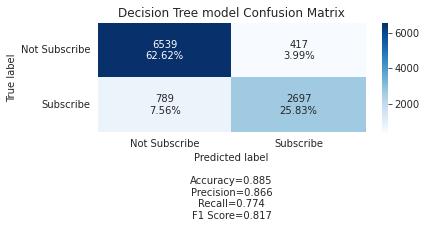

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion = "entropy", max_depth = 18, random_state = 0)
dt_model.fit(x_train, y_train)
y_pred = dt_model.predict(x_test)

matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, figsize=(6,2), categories = ['Not Subscribe', 'Subscribe'], title = 'Decision Tree model Confusion Matrix')

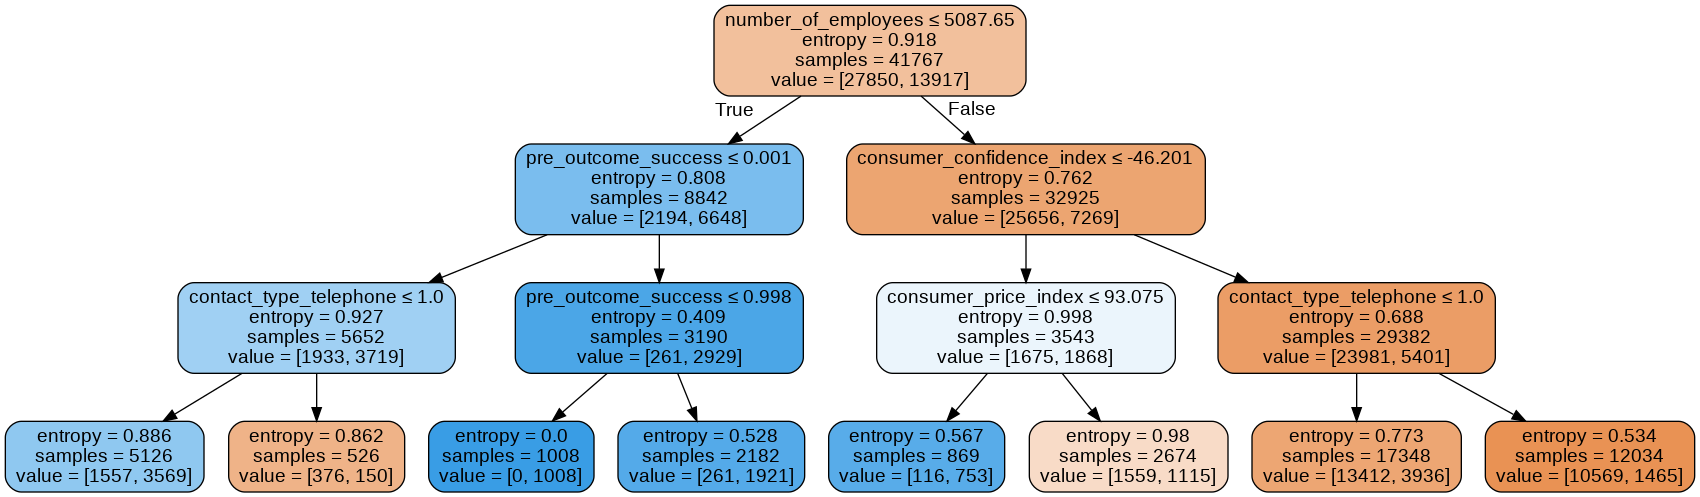

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion = "entropy", max_depth = 3, random_state = 0)
dt_model.fit(x_train, y_train)

feat_columns = df_dummies.drop('Subscribed_yes', axis = 1).columns
from six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os     
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

dot_data = StringIO()
export_graphviz(dt_model, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True, 
                feature_names = feat_columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree graph.png')

Image(filename = 'tree graph.png', width = 600, height = 200)

### 8. AdaBoost

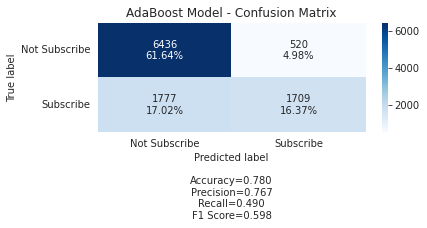

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators = 1) 
# This essentially implies that the AdaBoost classifier has to figure out the single best feature to split on.
# This is more in line with trying to figure out the most efficient area to look at versus trying to create the most perfect model.
ada_model.fit(x_train, y_train)
y_pred = ada_model.predict(x_test)

matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, figsize=(6,2), categories = ['Not Subscribe', 'Subscribe'], title = 'AdaBoost Model - Confusion Matrix')

In [ ]:
df_dummies.columns[dt_model.feature_importances_.argmax()]

'number_of_employees'

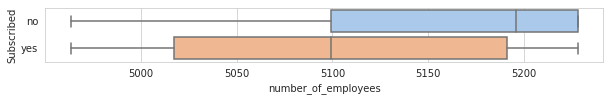

In [ ]:
plt.figure(figsize = (10, 1))
sns.boxplot(data = df, x = 'number_of_employees', y = 'Subscribed', palette = 'pastel')

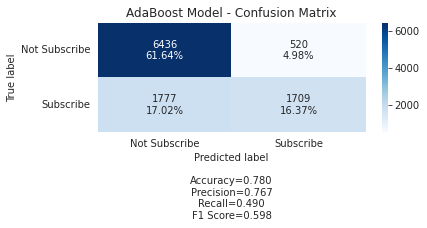

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators = 3) 
ada_model.fit(x_train, y_train)
y_pred = ada_model.predict(x_test)

matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(matrix, figsize=(6,2), categories = ['Not Subscribe', 'Subscribe'], title = 'AdaBoost Model - Confusion Matrix')

In [ ]:
dt_model.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.04560865,
       0.14196325, 0.        , 0.66191198, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06878377, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08173235])

In [ ]:
for i, col in enumerate(df_dummies.columns):
  print(i, ': ', col)

0 :  age
1 :  campaign
2 :  previous
3 :  employment_variation_rate
4 :  consumer_price_index
5 :  consumer_confidence_index
6 :  euribor3m
7 :  number_of_employees
8 :  job_blue-collar
9 :  job_entrepreneur
10 :  job_housemaid
11 :  job_management
12 :  job_retired
13 :  job_self-employed
14 :  job_services
15 :  job_student
16 :  job_technician
17 :  job_unemployed
18 :  job_unknown
19 :  marital_married
20 :  marital_single
21 :  marital_unknown
22 :  education_basic.6y
23 :  education_basic.9y
24 :  education_high.school
25 :  education_illiterate
26 :  education_professional.course
27 :  education_university.degree
28 :  education_unknown
29 :  has_credit_unknown
30 :  has_credit_yes
31 :  housing_unknown
32 :  housing_yes
33 :  loan_unknown
34 :  loan_yes
35 :  contact_type_telephone
36 :  month_aug
37 :  month_dec
38 :  month_jul
39 :  month_jun
40 :  month_mar
41 :  month_may
42 :  month_nov
43 :  month_oct
44 :  month_sep
45 :  day_of_week_mon
46 :  day_of_week_thu
47 :  day_o

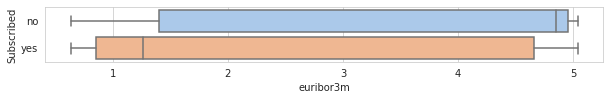

In [ ]:
plt.figure(figsize = (10, 1))
sns.boxplot(data = df, x = 'euribor3m', y = 'Subscribed', palette = 'pastel')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


[Text(0.5, 0, 'The outcome of previous campaign')]

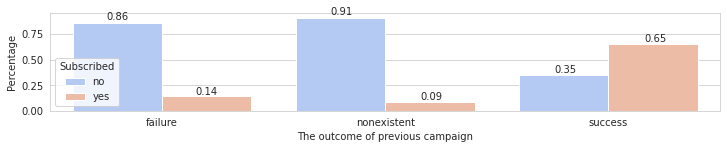

In [ ]:
df_wd = pd.DataFrame({'Count' : df.copy().groupby(['pre_outcome', 'Subscribed']).size()}).reset_index()

def total_check(x):
  return int(len(df[df['pre_outcome'] == x]))

df_wd['Total_of_success'] = df_wd['pre_outcome'].apply(lambda x: total_check(x))
df_wd['Count']         = pd.to_numeric(df_wd['Count'])
df_wd['Total_of_success'] = pd.to_numeric(df_wd['Total_of_success'])
df_wd['Percentage']    = round(df_wd['Count'] / df_wd['Total_of_success'], 2)

plt.figure(figsize = (12, 1.8))
g = sns.barplot(data = df_wd, x = 'pre_outcome', y = 'Percentage', hue = 'Subscribed',
                palette = 'coolwarm')
plt.legend(title='Subscribed', loc='lower left')

for p in g.patches:
  g.annotate(format(p.get_height(), '.2f'), 
             (p.get_x() + p.get_width() / 2., p.get_height()), 
             ha = 'center', va = 'bottom', 
             size= 10,
             textcoords = 'offset points')
g.set(xlabel='The outcome of previous campaign')